04.03.2021

uses A07tv instead of A06tv: for the classification timeline use the index not the filename.

Because with the index, data is numerical and we can use an numpy array and do not need pandas.

To get the information on the filenames we will have to run through the validation set once more, in an additional for loop.

to dos:
* finalize visualization for classification timeline: coloured backgrounds in red or green according to error or correct classification at final epoch? Run ctl only till the chosen epoch when the model was saved? Do it not in the mean for the repetitions, but for a fixed model. 
* Compare oscillation / confidence in classification between different architectures.
* compare confidence with accuracy: When confident, is the classification (mostly) correct? When not confident, is the classification mostly incorrect? 
* Compare: Oscillation for different ethniities or (gender, ethnicity) combinations.

dones:
* Visualise: Show oscillation and Image side by side for images with correct classification vs misclassification.
* change documentation of ctl prom dict and pandas to numpy in A07tv.py
* visualize oscillation of classification for validation images , for all the independent repetitions in a single plot
* small multiple of oscillations for 20 validation images
* boxplots for variation of oscillation in the independent repetitions (repeated training and validation loops over full num_episodes: clearly not random. Result: Oscillation in classification can be used as an indicator on how confident the algorithm is about the classification.

In [1]:
!pwd

/home/jovyan/LFI/bainbridge_2k/code


In [2]:
main_dir = '/home/jovyan/LFI/bainbridge_2k/'

# location of original labels: LFI/bainbridge_2k/meta
label_file = '../meta/labels2k_A_train.csv'

images_train_dir = '../images_train/'
images_test_dir = '../images_test/'

!ls $images_train_dir | wc -l 
!ls $images_test_dir | wc -l # both numbers should add to 2222 - 14 (doublettes) = 2208

# to build PATH to save the best model
model_dir = 'myModels/best/'

docume_dir = 'myModels/documentation/' # base directory, will get a subdir matching the model ( model.get_name() )

2108
100


In [2]:
'''# not necessary to run this - these requirements are already satisfied
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install torch
!pip install torchvision'''

'# not necessary to run this - these requirements are already satisfied\n!pip install numpy\n!pip install pandas\n!pip install matplotlib\n!pip install torch\n!pip install torchvision'

In [3]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import os

import torch
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# from torch.utils.data.sampler import SubsetRandomSampler, SequentialSampler

import torchvision
from torchvision import transforms, utils

import PIL

In [4]:
# plt.rcParams['figure.figsize'] = (10, 5)

In [4]:
def set_all_seeds(s): 
    # 1. Set `PYTHONHASHSEED` environment variable at a fixed value
    os.environ['PYTHONHASHSEED']=str(s)

    # 2. Set `python` built-in pseudo-random generator at a fixed value
    import random
    random.seed(s)

    # 3. Set `numpy` pseudo-random generator at a fixed value
    np.random.seed(s)

    # 4. Set `pytorch` pseudo-random generator at a fixed value
    torch.manual_seed(s)

# define the model

In [5]:
from myModels import myModels as mm # mm = myModels
!pip install pytorch_model_summary
import pytorch_model_summary as pms

  Using cached pytorch_model_summary-0.1.2-py3-none-any.whl (9.3 kB)


In [6]:
model = mm.MyNeuralNetwork3()

imgH, imgW = model.get_img_shape() # get the required image size for the model
# to be used in the transform of the Dataset

# order of imgH, imgW might be off. I have quadratic images so I don't care
print(pms.summary(model, torch.zeros((1, 3, imgH, imgW)), show_input=True))

-----------------------------------------------------------------------
      Layer (type)         Input Shape         Param #     Tr. Param #
          Conv2d-1      [1, 3, 64, 64]             112             112
       MaxPool2d-2      [1, 4, 64, 64]               0               0
       Dropout2d-3      [1, 4, 31, 31]               0               0
          Linear-4           [1, 3844]           7,690           7,690
          Linear-5              [1, 2]               6               6
Total params: 7,808
Trainable params: 7,808
Non-trainable params: 0
-----------------------------------------------------------------------


In [9]:
docume_dir_named = docume_dir+model.get_model_name()+'/'
print(model.get_model_name())
!ls $docume_dir

MyNeuralNetwork3
MyNeuralNetwork1-01  MyNeuralNetwork3-05		 MyNeuralNetwork6-02
MyNeuralNetwork3-01  MyNeuralNetwork3-06		 MyNeuralNetwork6-03
MyNeuralNetwork3-02  MyNeuralNetwork3_25training_epochs  MyNeuralNetwork6-04
MyNeuralNetwork3-03  MyNeuralNetwork6
MyNeuralNetwork3-04  MyNeuralNetwork6-01


if the directory already exist, it cannot be overwritten.

move the existing folder to a new name.

In [10]:
!mkdir $docume_dir_named

# Dataset and DataLoader for training (and val) set(s)

In [11]:
import A07tv as tv # train validate

In [12]:
df = pd.read_csv(label_file, index_col=0) 
df.index=range(df.shape[0])
setup = df[['Gender','Age','Race','newFilename']].copy()

# transform , no normalizing
transform = transforms.Compose([
    transforms.Resize((imgH,imgW)), # imgH, imgW as required for model
    transforms.ToTensor()
])

trainset = tv.TrainSet(setup=setup , transform=transform)

train_loader, val_loader = tv.loaders(trainset, setup) # batch_size=10, split=100 as defaults

In [13]:
len(val_loader.dataset) , len(train_loader.dataset)

(100, 2008)

## Train and validate

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print ("torch.cuda.is_available(): ", torch.cuda.is_available())

torch.cuda.is_available():  True


In [20]:
from copy import deepcopy

## model setup
# variable model holds the model defined in first paragraph.
model = model.to(device) # pushing to device before passing it ti training() and validate() functions

learning_rate = 0.001
momentum = 0.9
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
criterion = nn.CrossEntropyLoss()

print('**', model)

num_epochs = 50 # 50 when things run smoothly
C=2 # number of classes
T=5 # loops for statistical evaluation

# ctl : classification timeline
# only 1 epoch, not a timeline really
ctl_epoch = np.zeros((len(val_loader.dataset),2), dtype=np.int16) # 2 for index and prediction
# a real timeline
ctl = np.zeros((*ctl_epoch.shape, num_epochs), dtype=np.int16) # added dimension for each epoch
# independent repetitions of training and validation loops , a timeline for each repetition
docume_ctl = np.zeros((T,*ctl.shape), dtype=np.int16) 

docume_error = np.zeros((T,C,num_epochs), dtype=np.int8)
docume_tvla = np.zeros((T,4,num_epochs))
docume_ge = np.zeros((T,2,7,C,num_epochs), dtype=np.int8) # 2: 0,1 pred, label different or not, 7: number of ethnicities
docume_f1 = np.zeros((T,num_epochs))

good_seeds = [1,2,3,8,11,12] # for model 3 it happens that the model does not learn.
# we avoid these (bad) seeds.

for t in range(T):
    print('Repetition {}/{}'.format(t, T - 1))
    print('+' * 20)
    
    best_acc = 0.0
    stop_epoch = 0

    #seed_value = good_seeds[t]
    seed_value = good_seeds[t] 
    set_all_seeds(seed_value)
    
    for name, module in model.named_children():
        if hasattr(module, 'reset_parameters'):
            #print('resetting ', name)
            module.reset_parameters()
    
    train_acc_history = []
    val_acc_history = []

    train_loss_history = []
    val_loss_history = []

    val_fn_history = []
    val_fp_history = []
    
    f1_history =[]

    for epoch in range(num_epochs):

        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # train
        training_loss, training_acc = tv.training(model, train_loader, optimizer, criterion, device)
        train_loss_history.append(training_loss)
        train_acc_history.append(training_acc)

        # validation
        val_loss , val_cf_m , ctl_epoch, g_by_e, f1 = tv.validate(model, val_loader, criterion, device)
        # print('received from tv.validate : ' , ctl_epoch)
    
        if epoch==0:         
            g_by_e_hist = g_by_e[:,:,:].reshape((2,7,C,1))
            #print('epoch 0, g_by_e_hist :\n' , g_by_e_hist)
        else:
            g_by_e = g_by_e[:,:,:].reshape((2,7,2,1))
            g_by_e_hist = np.concatenate((g_by_e_hist, g_by_e), axis=3)
        
        val_loss_history.append(val_loss)
        
        tn, fp, fn, tp = val_cf_m.ravel()
        val_acc = (tp+tn)/len(val_loader.dataset)
        val_acc_history.append(val_acc)
       
        val_fn_history.append(fn)
        val_fp_history.append(fp)
        
        f1_history.append(f1)

        ctl[:,:,epoch]= ctl_epoch 
        
        # overall best model
        if val_acc > best_acc:
            best_acc = val_acc
            stop_epoch = epoch
            best_model_wts = deepcopy(model.state_dict())
            # docume_best_model just for surveillance. We only need best_model_wts
            # best_model_wts has length of 10, so I put it in a list. 
            # to extract it, use docume_best_model['state_dict'][0]
            # docume_best_model = docume_best_model.append(pd.DataFrame({'t':t,'epoch':epoch,'val acc':val_acc,'state_dict':[best_model_wts]}), ignore_index=True)
          
        ## end of train val epoch , go up to loop again or
    ## finish the train val epochs
    ## and document
        
    docume_error[t,0,:] = val_fn_history
    docume_error[t,1,:] = val_fp_history 
    
    docume_tvla[t,0,:] = train_loss_history # training, validation, loss and accuracy
    docume_tvla[t,1,:] = val_loss_history
    docume_tvla[t,2,:] = train_acc_history
    docume_tvla[t,3,:] = val_acc_history
    
    docume_ge[t,:,:,:] = g_by_e_hist
    
    docume_ctl[t,:,:,:] = ctl
    
    docume_f1[t,:] = f1_history
    
    print(f'Best acc in validation: {best_acc:4f}')

    # save the best model for final evaluation on test data
    PATH = model_dir+'{}_acc{}_epoch{}.pt'.format(model.get_model_name(), int(10000*best_acc), stop_epoch)
    torch.save(best_model_wts, PATH )

** MyNeuralNetwork3(
  (conv1): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (fc1): Linear(in_features=3844, out_features=2, bias=True)
  (fc2): Linear(in_features=2, out_features=2, bias=True)
)
Repetition 0/4
++++++++++++++++++++
Epoch 0/49
----------
Training Batch:    0 of 201
Training Batch:   50 of 201
Training Batch:  100 of 201
Training Batch:  150 of 201
Training Batch:  200 of 201
----------
Training Loss: 0.6751 Acc: 0.5647

Validation Batch:    0 of 10
----------
validation Loss: 0.6544 Acc: 0.5700

Epoch 1/49
----------
Training Batch:    0 of 201
Training Batch:   50 of 201
Training Batch:  100 of 201
Training Batch:  150 of 201
Training Batch:  200 of 201
----------
Training Loss: 0.6295 Acc: 0.5951

Validation Batch:    0 of 10
----------
validation Loss: 0.6294 Acc: 0.7600

Epoch 2/49
----------
Training Batch:    0 o

Training Batch:  150 of 201
Training Batch:  200 of 201
----------
Training Loss: 0.2380 Acc: 0.9084

Validation Batch:    0 of 10
----------
validation Loss: 0.2660 Acc: 0.8900

Epoch 28/49
----------
Training Batch:    0 of 201
Training Batch:   50 of 201
Training Batch:  100 of 201
Training Batch:  150 of 201
Training Batch:  200 of 201
----------
Training Loss: 0.2345 Acc: 0.9128

Validation Batch:    0 of 10
----------
validation Loss: 0.3509 Acc: 0.8700

Epoch 29/49
----------
Training Batch:    0 of 201
Training Batch:   50 of 201
Training Batch:  100 of 201
Training Batch:  150 of 201
Training Batch:  200 of 201
----------
Training Loss: 0.2535 Acc: 0.8984

Validation Batch:    0 of 10
----------
validation Loss: 0.2676 Acc: 0.8800

Epoch 30/49
----------
Training Batch:    0 of 201
Training Batch:   50 of 201
Training Batch:  100 of 201
Training Batch:  150 of 201
Training Batch:  200 of 201
----------
Training Loss: 0.2406 Acc: 0.9079

Validation Batch:    0 of 10
----------


----------
validation Loss: 0.4950 Acc: 0.7800

Epoch 6/49
----------
Training Batch:    0 of 201
Training Batch:   50 of 201
Training Batch:  100 of 201
Training Batch:  150 of 201
Training Batch:  200 of 201
----------
Training Loss: 0.4755 Acc: 0.8013

Validation Batch:    0 of 10
----------
validation Loss: 0.4784 Acc: 0.8300

Epoch 7/49
----------
Training Batch:    0 of 201
Training Batch:   50 of 201
Training Batch:  100 of 201
Training Batch:  150 of 201
Training Batch:  200 of 201
----------
Training Loss: 0.4604 Acc: 0.8093

Validation Batch:    0 of 10
----------
validation Loss: 0.4669 Acc: 0.8300

Epoch 8/49
----------
Training Batch:    0 of 201
Training Batch:   50 of 201
Training Batch:  100 of 201
Training Batch:  150 of 201
Training Batch:  200 of 201
----------
Training Loss: 0.4425 Acc: 0.8217

Validation Batch:    0 of 10
----------
validation Loss: 0.4564 Acc: 0.7800

Epoch 9/49
----------
Training Batch:    0 of 201
Training Batch:   50 of 201
Training Batch:  10

----------
validation Loss: 0.2201 Acc: 0.9000

Epoch 35/49
----------
Training Batch:    0 of 201
Training Batch:   50 of 201
Training Batch:  100 of 201
Training Batch:  150 of 201
Training Batch:  200 of 201
----------
Training Loss: 0.2285 Acc: 0.9168

Validation Batch:    0 of 10
----------
validation Loss: 0.2231 Acc: 0.9000

Epoch 36/49
----------
Training Batch:    0 of 201
Training Batch:   50 of 201
Training Batch:  100 of 201
Training Batch:  150 of 201
Training Batch:  200 of 201
----------
Training Loss: 0.2373 Acc: 0.9019

Validation Batch:    0 of 10
----------
validation Loss: 0.2113 Acc: 0.9200

Epoch 37/49
----------
Training Batch:    0 of 201
Training Batch:   50 of 201
Training Batch:  100 of 201
Training Batch:  150 of 201
Training Batch:  200 of 201
----------
Training Loss: 0.2381 Acc: 0.9089

Validation Batch:    0 of 10
----------
validation Loss: 0.1932 Acc: 0.9300

Epoch 38/49
----------
Training Batch:    0 of 201
Training Batch:   50 of 201
Training Batch:

Training Batch:  100 of 201
Training Batch:  150 of 201
Training Batch:  200 of 201
----------
Training Loss: 0.3210 Acc: 0.8700

Validation Batch:    0 of 10
----------
validation Loss: 0.3332 Acc: 0.8400

Epoch 14/49
----------
Training Batch:    0 of 201
Training Batch:   50 of 201
Training Batch:  100 of 201
Training Batch:  150 of 201
Training Batch:  200 of 201
----------
Training Loss: 0.3092 Acc: 0.8810

Validation Batch:    0 of 10
----------
validation Loss: 0.3724 Acc: 0.8300

Epoch 15/49
----------
Training Batch:    0 of 201
Training Batch:   50 of 201
Training Batch:  100 of 201
Training Batch:  150 of 201
Training Batch:  200 of 201
----------
Training Loss: 0.3004 Acc: 0.8755

Validation Batch:    0 of 10
----------
validation Loss: 0.3673 Acc: 0.8400

Epoch 16/49
----------
Training Batch:    0 of 201
Training Batch:   50 of 201
Training Batch:  100 of 201
Training Batch:  150 of 201
Training Batch:  200 of 201
----------
Training Loss: 0.2923 Acc: 0.8850

Validation B

Training Batch:  100 of 201
Training Batch:  150 of 201
Training Batch:  200 of 201
----------
Training Loss: 0.1834 Acc: 0.9343

Validation Batch:    0 of 10
----------
validation Loss: 0.2154 Acc: 0.8700

Epoch 43/49
----------
Training Batch:    0 of 201
Training Batch:   50 of 201
Training Batch:  100 of 201
Training Batch:  150 of 201
Training Batch:  200 of 201
----------
Training Loss: 0.1822 Acc: 0.9273

Validation Batch:    0 of 10
----------
validation Loss: 0.2773 Acc: 0.9100

Epoch 44/49
----------
Training Batch:    0 of 201
Training Batch:   50 of 201
Training Batch:  100 of 201
Training Batch:  150 of 201
Training Batch:  200 of 201
----------
Training Loss: 0.1874 Acc: 0.9298

Validation Batch:    0 of 10
----------
validation Loss: 0.2214 Acc: 0.9000

Epoch 45/49
----------
Training Batch:    0 of 201
Training Batch:   50 of 201
Training Batch:  100 of 201
Training Batch:  150 of 201
Training Batch:  200 of 201
----------
Training Loss: 0.1820 Acc: 0.9338

Validation B

Training Batch:  100 of 201
Training Batch:  150 of 201
Training Batch:  200 of 201
----------
Training Loss: 0.2927 Acc: 0.8835

Validation Batch:    0 of 10
----------
validation Loss: 0.3264 Acc: 0.8500

Epoch 22/49
----------
Training Batch:    0 of 201
Training Batch:   50 of 201
Training Batch:  100 of 201
Training Batch:  150 of 201
Training Batch:  200 of 201
----------
Training Loss: 0.2862 Acc: 0.8800

Validation Batch:    0 of 10
----------
validation Loss: 0.2894 Acc: 0.8700

Epoch 23/49
----------
Training Batch:    0 of 201
Training Batch:   50 of 201
Training Batch:  100 of 201
Training Batch:  150 of 201
Training Batch:  200 of 201
----------
Training Loss: 0.2801 Acc: 0.8865

Validation Batch:    0 of 10
----------
validation Loss: 0.2966 Acc: 0.8600

Epoch 24/49
----------
Training Batch:    0 of 201
Training Batch:   50 of 201
Training Batch:  100 of 201
Training Batch:  150 of 201
Training Batch:  200 of 201
----------
Training Loss: 0.2843 Acc: 0.8889

Validation B

Training Batch:  100 of 201
Training Batch:  150 of 201
Training Batch:  200 of 201
----------
Training Loss: 0.6752 Acc: 0.5827

Validation Batch:    0 of 10
----------
validation Loss: 0.6189 Acc: 0.6900

Epoch 1/49
----------
Training Batch:    0 of 201
Training Batch:   50 of 201
Training Batch:  100 of 201
Training Batch:  150 of 201
Training Batch:  200 of 201
----------
Training Loss: 0.5828 Acc: 0.6997

Validation Batch:    0 of 10
----------
validation Loss: 0.5514 Acc: 0.7500

Epoch 2/49
----------
Training Batch:    0 of 201
Training Batch:   50 of 201
Training Batch:  100 of 201
Training Batch:  150 of 201
Training Batch:  200 of 201
----------
Training Loss: 0.5436 Acc: 0.7510

Validation Batch:    0 of 10
----------
validation Loss: 0.5295 Acc: 0.8000

Epoch 3/49
----------
Training Batch:    0 of 201
Training Batch:   50 of 201
Training Batch:  100 of 201
Training Batch:  150 of 201
Training Batch:  200 of 201
----------
Training Loss: 0.5266 Acc: 0.7654

Validation Batc

Training Batch:   50 of 201
Training Batch:  100 of 201
Training Batch:  150 of 201
Training Batch:  200 of 201
----------
Training Loss: 0.2086 Acc: 0.9268

Validation Batch:    0 of 10
----------
validation Loss: 0.1953 Acc: 0.9200

Epoch 30/49
----------
Training Batch:    0 of 201
Training Batch:   50 of 201
Training Batch:  100 of 201
Training Batch:  150 of 201
Training Batch:  200 of 201
----------
Training Loss: 0.2448 Acc: 0.8999

Validation Batch:    0 of 10
----------
validation Loss: 0.2032 Acc: 0.9100

Epoch 31/49
----------
Training Batch:    0 of 201
Training Batch:   50 of 201
Training Batch:  100 of 201
Training Batch:  150 of 201
Training Batch:  200 of 201
----------
Training Loss: 0.2214 Acc: 0.9193

Validation Batch:    0 of 10
----------
validation Loss: 0.1895 Acc: 0.9100

Epoch 32/49
----------
Training Batch:    0 of 201
Training Batch:   50 of 201
Training Batch:  100 of 201
Training Batch:  150 of 201
Training Batch:  200 of 201
----------
Training Loss: 0.20

In [ ]:
# what exactly do we get from the validation(...) call?
e,c,p,r,f = tv.validate(model, val_loader, criterion, device) 
# returns epoch_loss, cf_m, pred_dict, recall_by_e
print('epoch loss : ' , e ,'\n')
print('confusion matrix :\n ' , pd.DataFrame(c), '\n')
print('array of predictions:\n' , p,'\n')
print('recall by ethnicity, correct: \n' , pd.DataFrame(r[0,:,:]),'\n')
print('recall by ethnicity, misclassified: \n' , pd.DataFrame(r[1,:,:]))

note that values in the confusion matrix can be obtained from the later recall by ethnicity matrix.

Also check that this is correckt in this special case. the columns in the e matrix sum to the entries in the confusion matrix.

In [21]:
# docume_error documents the error for T trainings, over num_epochs for both (C=2) classes
print('shape : ' , docume_error.shape) # T, C, num_epochs
m1 = docume_error.mean(axis=2) # mean over the epochs
m2 = docume_error.mean(axis=2).mean(axis=0) # overall mean error for the classes
print(m1.shape , m2.shape)
print(m1)
print(m2)

shape :  (5, 2, 50)
(5, 2) (2,)
[[ 5.36  8.62]
 [ 6.14  7.94]
 [ 5.72  8.68]
 [ 6.04 10.62]
 [ 4.4   7.04]]
[5.532 8.58 ]


# metrics
## loss and accuracy

Plot loss and accuracy for each repetition.

In [22]:
def plot_mat2d (mat_2d, set_title=None):
    if set_title is not None:
        assert type(set_title)==list, str(type(set_title))+' set_title should be a list of titles (str) for the subplots'
        assert len(set_title)==2 , 'need 2 titles for 2 subplots.'
    
    plt.figure(figsize=(12,4))
    
    plt.subplot(1, 2, 1)
    plt.plot(mat_2d[0,:], label='train loss')
    plt.plot(mat_2d[1,:], label='validation loss')
    plt.plot([0,num_epochs], [0.2,0.2], color='black', linewidth=0.7, linestyle = 'dotted')
    plt.xlabel('epoch')
    if set_title is None:
        plt.title('loss')
    else:
        plt.title(set_title[0])
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(mat_2d[2,:], label='train acc')
    plt.plot(mat_2d[3,:], label='validation acc')
    plt.plot([0,num_epochs], [0.9,0.9], color='black', linewidth=0.7, linestyle = 'dotted')
    plt.xlabel('epoch')
    if set_title is None:
        plt.title('accuracy')
    else:
        plt.title(set_title[1])
    plt.legend()
    plt.savefig(docume_dir_named+'loss_acc'+str(t)+'.png')
    plt.show()

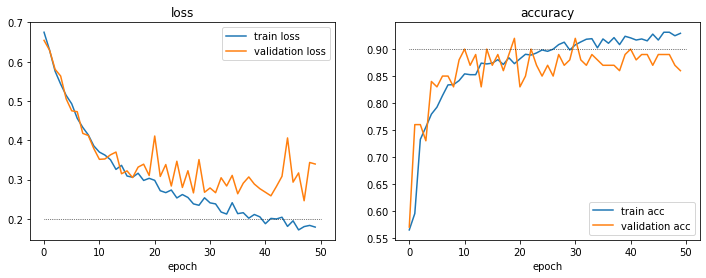

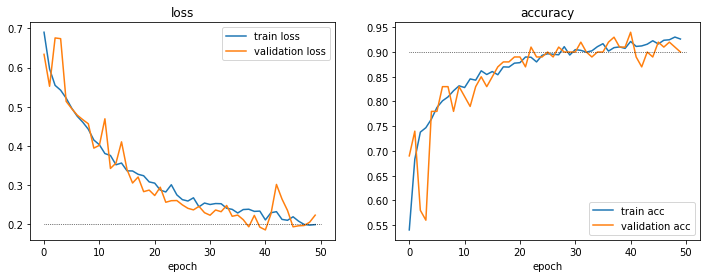

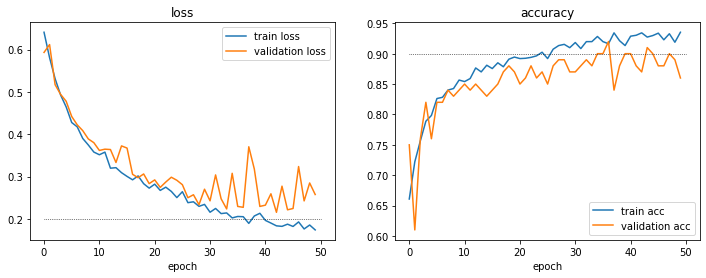

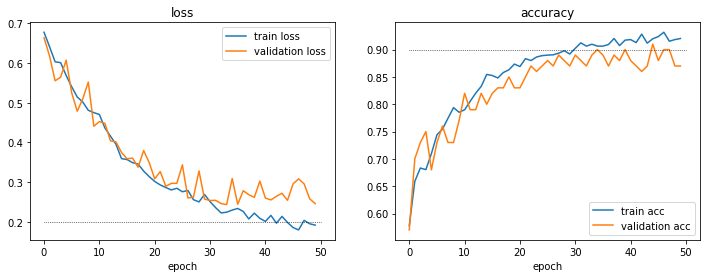

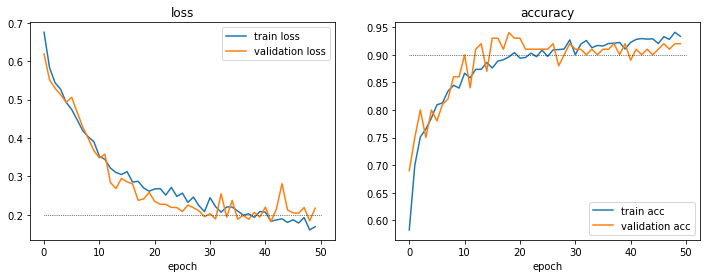

In [23]:
for t in range(T):
# for t in range(1,T-1):
    plot_mat2d(docume_tvla[t,:,:])

For T=5 the model did  not learn anything in 2 repetitions. The architecture completely failed 40% of the time!

For T=10 the model did not learn anything in 4 repetitions. The architecture completely failed 40% of the time!
That is bad but it can be avoided :-) by just starting again with another seed.

We continue to work with only the training validation loops / repetitions when the model did learn something.

In [24]:
# remove repetitions (of independent train val loops) when the model did not lern anything
# not needed at the moment
'''
print('before : ' , docume_error.shape)
if docume_error.shape[0]==T: 
    if T==5:
        # use only repetitions when the network did learn something
        docume_error = docume_error[1:T-1,:,:]
        docume_tvla = docume_tvla[1:T-1,:,:]
        docume_f1 = docume_f1[1:T-1,:]
        docume_ge = docume_ge[1:T-1,:,:,:]
        docume_ctl = docume_ctl[1:T-1,:,:,:]
    elif T==10: # repetitions when model does not learn: 0,5,6,7
        docume_error = docume_error[(1,2,3,4,8,9),:,:] # this is not slicing?!
        docume_tvla = docume_tvla[(1,2,3,4,8,9),:,:]
        docume_f1 = docume_f1[(1,2,3,4,8,9),:]
        docume_ge = docume_ge[(1,2,3,4,8,9),:,:,:]
        docume_ctl = docume_ctl[(1,2,3,4,8,9),:,:,:]
else:
    print('check if repetitions have been removed correctly / before.')
print('after : ' , docume_error.shape)'''

"\nprint('before : ' , docume_error.shape)\nif docume_error.shape[0]==T: \n    if T==5:\n        # use only repetitions when the network did learn something\n        docume_error = docume_error[1:T-1,:,:]\n        docume_tvla = docume_tvla[1:T-1,:,:]\n        docume_f1 = docume_f1[1:T-1,:]\n        docume_ge = docume_ge[1:T-1,:,:,:]\n        docume_ctl = docume_ctl[1:T-1,:,:,:]\n    elif T==10: # repetitions when model does not learn: 0,5,6,7\n        docume_error = docume_error[(1,2,3,4,8,9),:,:] # this is not slicing?!\n        docume_tvla = docume_tvla[(1,2,3,4,8,9),:,:]\n        docume_f1 = docume_f1[(1,2,3,4,8,9),:]\n        docume_ge = docume_ge[(1,2,3,4,8,9),:,:,:]\n        docume_ctl = docume_ctl[(1,2,3,4,8,9),:,:,:]\nelse:\n    print('check if repetitions have been removed correctly / before.')\nprint('after : ' , docume_error.shape)"

In [25]:
# uncomment this cell if the last repetition got stuck at accuracy 57%, predicting all 'male'
'''docume_error = docume_error[:T-1,:,:]
docume_tvla = docume_tvla[:T-1,:,:]
docume_f1 = docume_f1[:T-1,:]
docume_ge = docume_ge[:T-1,:,:,:]
docume_ctl = docume_ctl[:T-1,:,:,:]'''

'docume_error = docume_error[:T-1,:,:]\ndocume_tvla = docume_tvla[:T-1,:,:]\ndocume_f1 = docume_f1[:T-1,:]\ndocume_ge = docume_ge[:T-1,:,:,:]\ndocume_ctl = docume_ctl[:T-1,:,:,:]'

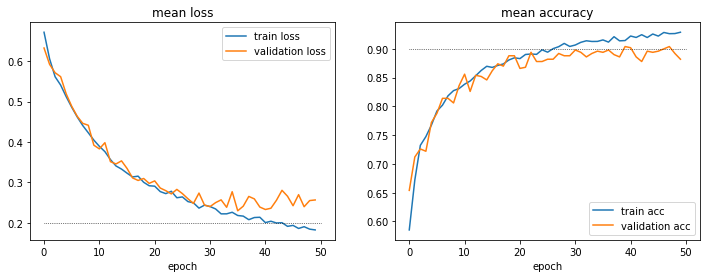

<Figure size 432x288 with 0 Axes>

In [26]:
plot_mat2d(docume_tvla.mean(axis=0), set_title=['mean loss', 'mean accuracy'])
plt.savefig(docume_dir_named+'loss_acc_mean.png')
plt.show()

## result from loss acc plots

### bias variance trade-off, early stopping

The mean of the training set accuracy (mean over the repetitions where the model actually does learn) rises to 90% after around 25 epochs, gets to almost 95% after 50 trining epochs. This indicates that the model can well differentiate b/w the given labels. There is an estimated 10% bias but no (heavy) bias problem.

The training loss starts at around 0.7 which is close to -ln1/2 (2=C=number of classes and) continuously declines, which is good.

Since the validation (same mean as before) mean accuracy stays below 90% we have some variance remaining in our model / data set. The validation loss never reaches 0.2, it stops declining after about 30 epochs. 

The performance of this model is limited but not bad for my purpose.

The model should be trained around 25 to 30 epochs. After that overfitting starts.

In [27]:
est_early_stop_time = 30

### other stuff

The model from repetition t=2 gets the best validation results in acc and loss. However, this is probably due to a good match to the valation set. So it is a way of overfitting the validation set which will not help with the test set.

The mean accuracy tells me we can expect an accuracy on the test set of about 90%. Since the test set is itself random we would like to get a conf intervall. We could obtain this from the dev sets, maybe with more repetitions, i.e. a larger T.

Also it would be nice to have an automatic vis of the confInt...

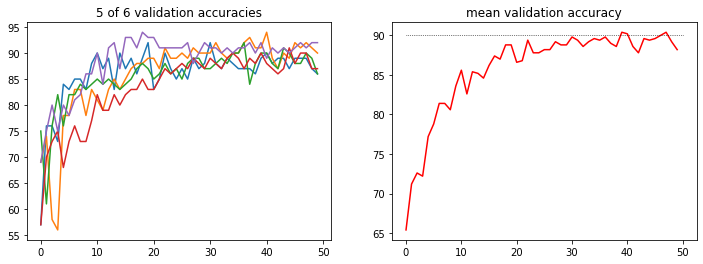

In [21]:
# for more than 3 lines (T>3) it is better to plot the mean in a separate coord system 
# accuracy timeline : 100 - misclassified = 100 - fp - fn
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.plot((100-docume_error.sum(axis=1)).T, label=range(2))
plt.title(str(docume_error.shape[0])+' of '+str(T)+' validation accuracies')
plt.subplot(1,2,2)
plt.plot(np.mean((100-docume_error.sum(axis=1)).T,axis=1), label='mean', color='red')
plt.plot([0,num_epochs], [90,90], color='black', linewidth=0.7, linestyle = 'dotted')
plt.title('mean validation accuracy')

plt.savefig(docume_dir_named+'accuracies.png')
plt.show()

## f1 score, not weighted (anymore, changed it in tv.validate)
Since I don't really know what weighted means, I should not use it.

(5, 50)


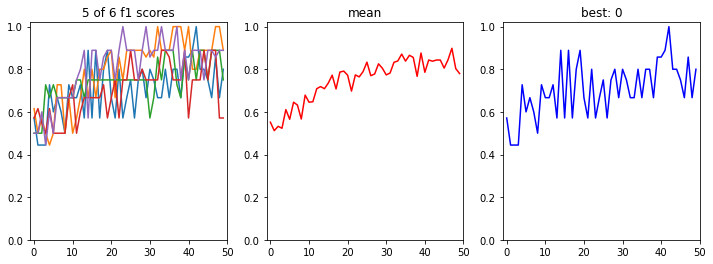

In [22]:
plt.figure(figsize=(12,4))
plt.subplot(1, 3, 1)
plt.plot(docume_f1.T)
plt.axis((-1,num_epochs,0,1.02))
plt.title(str(docume_error.shape[0])+' of '+str(T)+' f1 scores')
############################################
plt.subplot(1,3,2)
#plt.plot(docume_f1.T)
plt.plot(np.mean(docume_f1.T,axis=1), label='mean', color='red')
#plt.plot([0,num_epochs], [90,90], color='black', linewidth=0.7, linestyle = 'dotted')
plt.axis((-1,num_epochs,0,1.02))
plt.title('mean')
#############################################
plt.subplot(1,3,3)
print(docume_f1.shape)
#  print(np.argmax(docume_f1,axis=0))
best_in_rep = np.argmax(docume_f1,axis=1)
best = np.argmax([docume_f1[idx,best_in_rep[idx]] for idx in range(len(best_in_rep))])
#plt.plot(docume_f1.T)
plt.plot(docume_f1[best,:], color='blue')
plt.axis((-1,num_epochs,0,1.02))
#plt.plot([0,num_epochs], [90,90], color='black', linewidth=0.7, linestyle = 'dotted')
plt.title('best: '+str(best))
plt.savefig(docume_dir_named+'f1.png')
plt.show()



## error analysis by gender
with respect to the labeled genders. Up to now we looked into loss and accuracy for the train and dev set, ot differentiating b/w the labels of the images. Now we want to look into how each gender performs.

### Mean confusion matrix at estimated stopping epoch

In [23]:
cfm= pd.DataFrame([docume_ge[:,:,:,0,est_early_stop_time].mean(axis=0).sum(axis=1),
docume_ge[:,:,:,1,est_early_stop_time].mean(axis=0).sum(axis=1)[::-1]], columns=['classif f','classif m'], index=['label f','label m'])
cfm
# docume_ge[:,:,:,0,est_early_stop_time].mean(axis=0).sum(axis=1) # labeled female

,classif f,classif m
label f,36.0,7.0
label m,3.2,53.8


In [24]:
docume_f1[:,est_early_stop_time].mean()
#docume_f1.shape

0.7734920634920636

[[3 9]
 [4 6]
 [4 9]
 [6 7]
 [3 5]]


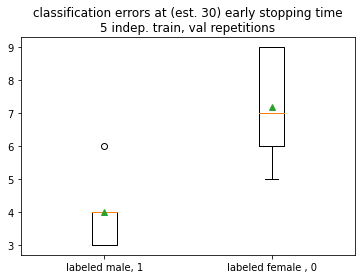

In [25]:
# data = docume_error[:,:,num_epochs-1] # error at final classification
data = docume_error[:,:,est_early_stop_time-1] # error at early stopping time
print(data)
fig, ax = plt.subplots()
ax.boxplot(data, showmeans=True , labels=['labeled male, 1','labeled female , 0'])
#plt.legend(['fp','fn'])
plt.title('classification errors at (est. {}) early stopping time\n{} indep. train, val repetitions'.format(est_early_stop_time, data.shape[0]))
plt.savefig(docume_dir_named+'boxplot_error.png')
plt.show()

### error timeline by gender

In [26]:
def print_errors_by_label (docume):
    T = docume.shape[0]
    #print(plt.figure.params)
    if T < 4:
        plt.figure(figsize=(4*T,4))
    elif T <7:
        plt.figure(figsize=(4*(T//2+1),8))
    #eps = docume.shape[2] # num_epochs
    #T = docume.shape[0]
    # to set a uniform y axis, find the max value in 3rd for all t<=T and c<=C
    y_max = max(docume.max(axis=2).ravel())
    #print(y_max)
    
    for t in range(T):
        if T<4:
            plt.subplot(1, T, 1+t)
        elif T<7:
            plt.subplot(2, (T+1)//2, 1+t)
        plt.axis((-0.5,num_epochs,-0.5,y_max+0.5))
        plt.plot(docume[t,1,:], label='labeled female, fp')
        plt.plot(docume[t,0,:], label='labeled male, fn')
        plt.xlabel('epoch')
        #plt.ylabel('nr. missclassified')
        #plt.title('Types of missclassification')
        plt.legend()
    plt.savefig(docume_dir_named+'ctl_error.png')
# docume[t,0,0:num_epochs] = val_fn_history

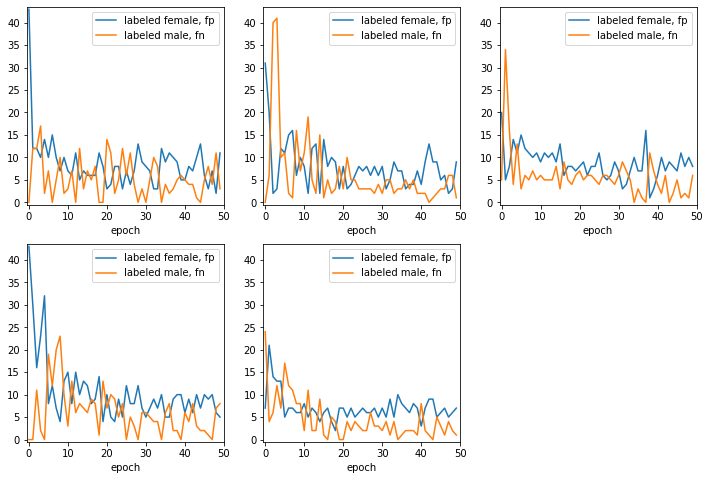

In [27]:
print_errors_by_label(docume_error)

In some runs, in absolute numbers the classification errors for labeled female and labeled male were about the same. This implies a higher proportion of missclassifications in females when compared to males.

But this is what will often happen when you go for few misclassifications. It basically does not matter whom you misclassify. Relative misclassification will always put the dominant class in the better position.

However, in this run (with seeds at 2 stages: when splitting into train/val sets and when running the training (important for random initilisation, say) labeled females were misclassified more often than males, though they amount for less than hals of the validation data. 

We have spotted an aspect of unfairness.

We should check that this is statistically significant.

How labeled females have a higher (absolute) error rate than males. This gets worse when we look into the relative error for the classes since there are more images labeled male in the data set (stratified split, so this holds for the training and validation set).

(2, 50)


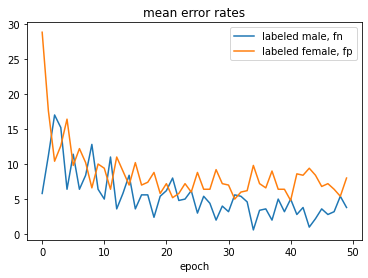

In [28]:
# errors for the classes , recall for labeled female and labeled male
ctl_mean = docume_error.mean(axis=0)
print(ctl_mean.shape)
plt.subplot(1, 1, 1)
plt.plot(ctl_mean.T)
plt.xlabel('epoch')
plt.legend(['labeled male, fn','labeled female, fp'])
plt.title('mean error rates')
plt.savefig(docume_dir_named+'ctl_error_mean.png')

We look at the error at the estimated stopping time. A box plot allows for easy observation of statistical significance (no test needed ...):

It should be noted that the disparity / difference b/w the genders gets more significant / gets worse / oscillates less as the model overfits the training data. This shows a clear trend.

Around the estimated early stopping time after 25 epochs, the boxplot shows a significant (as meets the eye, though I should have more independent repetitions) difference for the classification errors of ach gender group.

## error analysis by gender and ethnicity
during training we documented errors with respect to gender and ethnicity for the dev set. Now we want to look into how each gender and ethnicity combination performed.

[[31.2 43.2  4.8  3.8]
 [ 2.4  6.   1.6  0. ]
 [ 1.2  0.8  0.8  0.2]
 [ 0.   0.   0.   0. ]
 [ 1.   2.   0.   0. ]
 [ 0.   1.   0.   0. ]]
gender ethnicity documentation over epochs is reuced:
mean over repetitions, only estimated early stopping epoch.

6 sparcly populated ethnic categories

   f correct  m correct  f miscl  m miscl
0       31.2       43.2      4.8      3.8
1        2.4        6.0      1.6      0.0
2        1.2        0.8      0.8      0.2
3        0.0        0.0      0.0      0.0
4        1.0        2.0      0.0      0.0
5        0.0        1.0      0.0      0.0

add ethnic categories 2,3,4,5: 2 asian, 1 latin and 1 other category.
       f correct  m correct  f miscl  m miscl
white       31.2       43.2      4.8      3.8
black        2.4        6.0      1.6      0.0
other        2.2        3.8      0.8      0.2

add column for totals and percentage


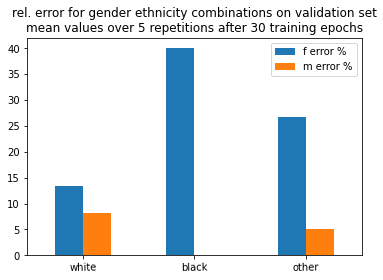

In [29]:
#print(docume_ge.shape)
a = docume_ge[:,:,:,:,est_early_stop_time-1].mean(axis=0) 

# data reduction: fixed epoch at estimated stopping time
# Check, if this is reproduced 
# or changed when changing the seeds for the repetitions

data = np.concatenate([a[0,1:,:], a[1,1:,:]], axis=1) # exclude ethnicity 0
print(data)
df= pd.DataFrame(data, index=range(6), columns=['f correct','m correct','f miscl','m miscl'])
print('gender ethnicity documentation over epochs is reuced:\nmean over repetitions, only estimated early stopping epoch.\n')
print('6 sparcly populated ethnic categories\n')
print(df)
print('\nadd ethnic categories 2,3,4,5: 2 asian, 1 latin and 1 other category.')

data= np.concatenate([data[0:2,:] , [np.sum(data[2:6,:],axis=0)]], axis=0)
#print(data)
#print('****')
df= pd.DataFrame(data, index=['white','black','other'], columns=['f correct','m correct','f miscl','m miscl'])
print(df)
print('\nadd column for totals and percentage')
df['f totals'] = df['f correct']+df['f miscl']
df['m totals'] = df['m correct']+df['m miscl']
df['f error %']= round(100*df['f miscl']/(df['f correct']+df['f miscl']),1)
df['m error %']= round(100*df['m miscl']/(df['m correct']+df['m miscl']),1)

# labels on x axis should be ['undef','white','black','other']
df[['f error %','m error %']].plot.bar(\
    rot = 1, \
    legend= True, \
    title='rel. error for gender ethnicity combinations on validation set\nmean values over {} repetitions after {} training epochs'.format(docume_ge.shape[0],est_early_stop_time))
#df#.plot.bar()
plt.savefig(docume_dir_named+'error_rates_grouped_by_ethnicity.png')

## documentation of classification errors during training process
only for the validation images. I have to make sure I am accessing the validation images and can identify each image. I need to know how the classification of each image changes over time. This is why I use a dictionary with the key equal to the filename.

Create an time series for each test image. 

# classification timeline
We first look into a single classification timeline. ctl is the abbreviation for classification timeline. For each repetition (t) for image i we get a timeline of classifications during the training epochs.

In [28]:
docume_ctl[0,5,:,:] # first repetition, 6th image contains: 
# the index (unneccessary repetition, waste of memory, sorry) 
# and the classification values in 0 and 1
docume_ctl[0,5,1,:]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1], dtype=int16)

How classifications change over the course of 50 training epochs (no mean taken, just a singele training, validation run over 50 epochs)

(100, 2, 50)


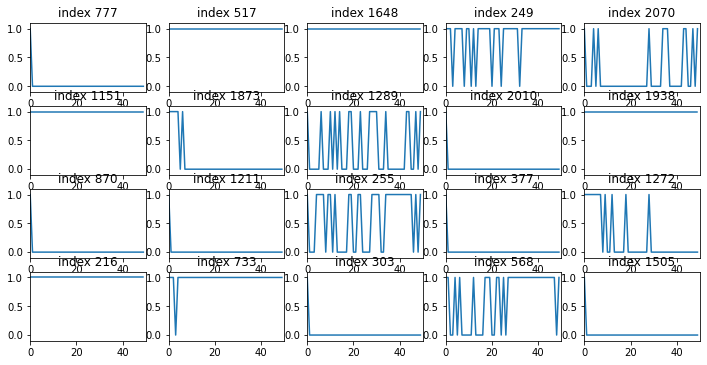

In [29]:
ctl=docume_ctl[0,:,:,:] # t=0 a fixed independent repetition, one training loop of 50 epochs
print(ctl.shape)
plt.figure(figsize=(12,15))
for i in range(20): 
    plt.subplot(10, 5, i+1)
    plt.axis((0,num_epochs,-0.1,1.1))
    plt.title('index {}'.format(ctl[i,0,0]))
    plt.plot(ctl[i,1,:])
plt.savefig(docume_dir_named+'oscillation.png')

To check if this is consistent we take plot all 6 repetitions for each image in one plot.

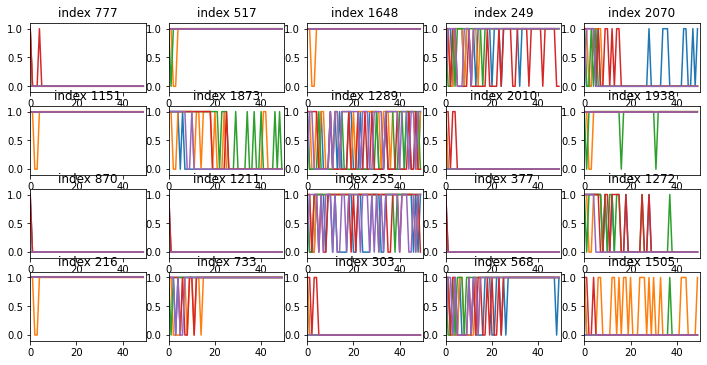

In [30]:
plt.figure(figsize=(12,15))
for i in range(20): # i ranges over the distinctive images , not the index
    #print(ctl[i,1,:]) # 1 is the classification data , 0 would be the index
    plt.subplot(10, 5, i+1)
    plt.axis((0,num_epochs,-0.1,1.1))
    plt.title('index {}'.format(docume_ctl[0,i,0,0]))
    plt.plot(docume_ctl[:,i,1,:].T)
    #ctl[ctl.columns[i]].plot()
plt.savefig(docume_dir_named+'oscillation_{}repetitons.png'.format(docume_ctl.shape[0]))

To better evaluate this we look at the number of changes in each independent repetition in a boxplot.

In [31]:
# for each row in a matrix count the numbers of changes in the row
# all epochs-1 (= number of tupels (2-tupels) of sequential epochs, anzahl von Paaren aufeinanderfolgender classifications)
# minus the number of times when both classifications in a tupel are equal

def count_changes(a):
    '''a a vector shape (1,n) or a matrix shape (m,n). Count for each row how often values change'''
    assert len(a.shape) ==2 , 'a should have 2 dimensions. You do the slicing, not me!'
    m,n = a.shape 
    return [n-1-[a[j,k+1]-a[j,k] for k in range(n-1)].count(0) for j in range(m)]

We do not count changes in the first 5 epochs. The algorithm is just warming up. We used default initialisation of weights. And no centering, scaling (subtract mean, divide by std). Maybe bias has to be learned.

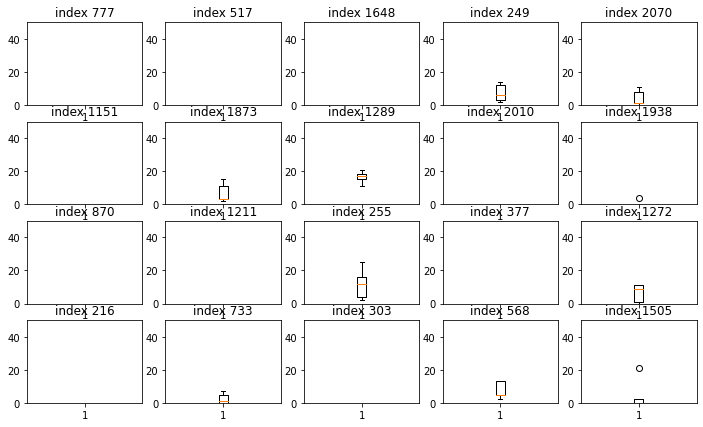

In [32]:
#create a pandas
df = pd.DataFrame(docume_ctl[0,:,0,0])
# visualize
plt.figure(figsize=(12,7))
for i in range(20):
    #a = docume_ctl[:,i,1,:] # 2 dim , flat,; row for repetiton, column for epoch
    plt.subplot(4, 5, i+1)
    #b=[num_epochs-1-[a[j,k+1]-a[j,k] for k in range(num_epochs-1)].count(0) for j in range(a.shape[0])]
    #print(b)
    plt.boxplot(count_changes(docume_ctl[:,i,1,5:]))
    plt.axis((0,2,0,num_epochs))
    plt.title('index {}'.format(docume_ctl[0,i,0,0]))
plt.show()

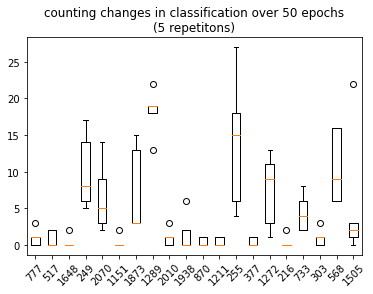

In [35]:
# create a pandas data frame
# create the index of rows , the index in the dataloader
df = pd.DataFrame({'index': docume_ctl[0,:,0,0]}).set_index('index')
# print(docume_ctl.shape)
#create columns, one for each repetition (Dont use T, because some repetitons were removed (algo did not learn))
for t in range(docume_ctl.shape[0]):
    df[str(t)]= 0

for i in range(docume_ctl.shape[1]): # loop through images (via their index, as in labels_i, labels['index'] returned by dataloader)
    df.iloc[i]= count_changes(docume_ctl[:,i,1,:])
# print(df.iloc[0:20])

plt.title('counting changes in classification over {} epochs\n({} repetitons)'.format(num_epochs, docume_ctl.shape[0]))
plt.boxplot(df.iloc[0:20])
# draw index as xlabel
# plt.xticks([range(20)], docume_ctl[0,0:20,0,0], size='small')
plt.xticks(ticks=list(range(1,21)),labels=list(df.index[0:20]),rotation=45)
plt.savefig(docume_dir_named+'oscillation_{}repetitons_boxplot.png'.format(docume_ctl.shape[0]))
plt.show()

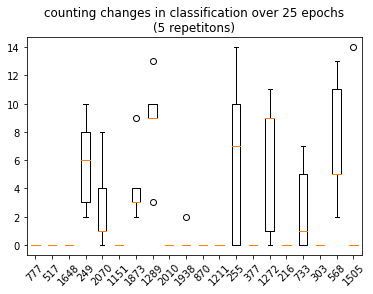

In [34]:
leave_out_initial_epochs = 5
# create a pandas data frame
# create the index of rows , the index in the dataloader
df = pd.DataFrame({'index': docume_ctl[0,:,0,0]}).set_index('index')
# print(docume_ctl.shape)
#create columns, one for each repetition (Dont use T, because some repetitons were removed (algo did not learn))
for t in range(docume_ctl.shape[0]):
    df[str(t)]= 0

for i in range(docume_ctl.shape[1]): # loop through images (via their index, as in labels_i, labels['index'] returned by dataloader)
    df.iloc[i]= count_changes(docume_ctl[:,i,1,leave_out_initial_epochs:est_early_stop_time])
# print(df.iloc[0:20])

plt.title('counting changes in classification over {} epochs\n({} repetitons)'.format(est_early_stop_time-leave_out_initial_epochs, docume_ctl.shape[0]))
plt.boxplot(df.iloc[0:20])
# draw index as xlabel
# plt.xticks([range(20)], docume_ctl[0,0:20,0,0], size='small')
plt.xticks(ticks=list(range(1,21)),labels=list(df.index[0:20]),rotation=45)
plt.savefig(docume_dir_named+'oscillation_{}repetitons_boxplot.png'.format(docume_ctl.shape[0]))
plt.show()

Looking at all images in the validation set side by side with their boxplot for the number of changes during 50 training, validation episodes.

In [ ]:
with torch.no_grad():
    for img, lab in val_loader.dataset:
        print('the labels : ' , lab['index'],lab['file'], ('male' if lab['gender'] else 'female'))

        # subplot 1 : the image
        plt.subplot(121)
        plt.imshow(img.permute(1,2,0))
        plt.axis('off')

        # subplot 2 : the box plot
        plt.subplot(122)
        plt.boxplot(list(df.loc[int(lab['index'])]))
        plt.axis((0,2,0,num_epochs))
        plt.show()

My brain does not detect a pattern from staring at these images.

## algorithm's confidence in classification
no or low oscillation, low number of change in classification can be interpreted as confidence. The algorithm mostly stays at the same classification as before.

(Another interpretation is: The algorithm ignores the image...)

look at images from selected intersectional subgroups with a threshold on their oscillation / number of changes in classification. 

In [39]:
leave_out_initial_epochs = 5
for i , (img, lab) in enumerate(val_loader.dataset):
    assert lab['index']==docume_ctl[0,i,0,0] , 'matching images gone wrong'
    osc = np.mean(count_changes(docume_ctl[:,i,1,leave_out_initial_epochs:])) / (docume_ctl.shape[3] -leave_out_initial_epochs)
    mean_classif = docume_ctl[:,i,1,est_early_stop_time].mean(axis=0)
    if lab['gender']== 0:
        if lab['ethnicity']==1:
            if osc < 0.2 :
                if np.abs(lab['gender'] - mean_classif) < 0.2:
                    print(lab['file'])
                    #plt.subplot(111)
                    plt.figure(figsize=(2, 2))
                    plt.imshow(img.permute(1,2,0))
                    plt.axis('off')
                    plt.show()

10


Build a table / data frame to collect data from labels and data about oscillation / number of changes during 50 training epochs.

In [35]:
leave_out_initial_epochs = 5
dict1 = {}
print(len(val_loader))
for i , (img, lab) in enumerate(val_loader.dataset):
    assert lab['index']==docume_ctl[0,i,0,0] , 'matching images gone wrong'
    dict1[lab['index']]=[lab['gender'], \
                         lab['ethnicity'], \
                         np.mean(count_changes(docume_ctl[:,i,1,leave_out_initial_epochs:est_early_stop_time])), \
                         # should count only changes until the est_early_stop_time (= 30) ?!
                         docume_ctl[:,i,1,est_early_stop_time].mean(axis=0) , \
                         lab['file']]
g = pd.DataFrame.from_dict(dict1, orient='index', columns=['gender','ethnicity','mean changes','mean classification at eese', 'image name'])
# g['ethnicity'].mean(axis=0) # they are not all white?!, mean > 1!
g['d']= abs(g['gender'] - g['mean classification at eese'])
g

10


,gender,ethnicity,mean changes,mean classification at eese,image name,d
777,0,1,0.0,0.0,983.jpg,0.0
517,1,1,0.0,1.0,400.jpg,0.0
1648,1,1,0.0,1.0,2105.jpg,0.0
249,1,1,5.8,0.8,401.jpg,0.2
2070,0,1,2.8,0.0,1110.jpg,0.0
...,...,...,...,...,...,...
1985,0,1,2.6,0.0,327.jpg,0.0
1797,1,1,6.8,0.8,421.jpg,0.2
545,0,1,0.0,0.0,813.jpg,0.0
2002,0,1,0.0,0.0,1190.jpg,0.0


and visualise confidence: plotting 
* on the x-axis : the difference of the gender label and the mean classification at the estimated early stopping epoch
* on the y axis: the oscillation, the mean number of changes in classification

It would have been nice to get info on ethnicity and gender in one plot... here it is distributed over 2 plots:

Text(0.5, 1.0, 'Changes in classification during training epochs\n(bottom left: confident and correct)')

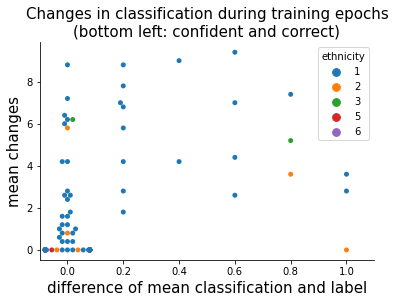

In [51]:
import seaborn as sns

sns.swarmplot('d','mean changes', data = round(g,2) , hue='ethnicity')
sns.despine()
plt.xlabel("difference of mean classification and label", size=15)
plt.ylabel('mean changes', size=15)
plt.title('Changes in classification during training epochs\n(bottom left: confident and correct)', size=15)

Text(0.5, 1.0, 'Changes in classification during training epochs\n(bottom left: confident and correct)')

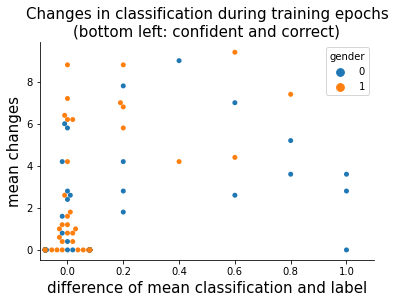

In [52]:
sns.swarmplot('d','mean changes', data = round(g,2) , hue='gender')
sns.despine()
plt.xlabel("difference of mean classification and label", size=15)
plt.ylabel('mean changes', size=15)
plt.title('Changes in classification during training epochs\n(bottom left: confident and correct)', size=15)

Interpretation: in the bottom left corner are images that are correctly classified and have seen few changes in their classification: The algorithm works correctly and is confident about it. Well done!

All plotted points above a horizontal line at y=6, for example, represent images with a high number of changes in classification. The algorithm is not confident about classifying these images.

All plotted points on the right hand side of a vertical line at x=0.5 have been misclassified most of the time.

The dots on the far right with x=1.0 have always been misclassified. The lower the y value the more confident the algorithm is, and since in this case confidence is not paired with correctness, we can say the algorithm was oblivious about making an error. 

Now, lets look at the images behind the plotted points:

In [ ]:
def vis_me (data_frame, col_name):
    for fn in data_frame[col_name]:
        #print(fn)
        img = PIL.Image.open(images_train_dir+fn)
        plt.imshow(img)#.permute(1,2,0))
        plt.title(fn)
        plt.axis('off')
        plt.show()


In [ ]:
# Select statement in pandas: df.loc[df['column_name'] == some_value]

# many changes in classification
vis = g.loc[g['mean changes']>10] # result: gender evenly split , ethnicity almost all white
vis_me(vis, 'image name')
vis

Plotted point in bottom right corner: low number of changes in classification (=confidence) but mostly misclassified:

In [ ]:
# few changes and misclassified
vis = g.loc[(g['mean changes']<3) & (g['d'] > 0.5) ] # result: consistently misclassified. always as gender 1
vis_me(vis, 'image name')
vis